In [1]:
# ! sed 's/\r//g' data/ai.ja.txt | cabocha -f1 > data/ai.ja.cabocha

In [2]:
# pip install ginza

In [3]:
! sed 's/\r//g' data/ai.ja.txt | ginza -f cabocha > data/ai.ja.cabocha

### 40. 係り受け解析結果の読み込み（形態素）

In [4]:
class Morph:
    def __init__(self, line):
        line = line.split('\t')
        self.surface = line[0]
        features = line[1].split(',')
        self.base = features[6]
        self.pos = features[0]
        self.pos1 = features[1]
        self.pos2 = features[2]
        
    def __repr__(self):
        return self.surface

In [5]:
with open('data/ai.ja.cabocha') as f:
    data = f.read().splitlines()

In [6]:
text = []
sentence = []
for line in data:
    if line == 'EOS':
        if sentence: # cabochaだと"EOS\nEOS" が文の区切りになるので必要
            text.append(sentence)
            sentence = []
    elif line != '' and (not line.startswith('*')):
        morph = Morph(line)
        sentence.append(morph)

In [7]:
text[33]

[ジョン,
 ・,
 マッカーシー,
 は,
 AI,
 に,
 関する,
 最初,
 の,
 会議,
 で,
 「,
 人工知能,
 」,
 と,
 いう,
 用語,
 を,
 作り出し,
 た,
 。]

### 41. 係り受け解析結果の読み込み（文節・係り受け）

In [8]:
import re

In [9]:
class Chunk(list):
    def __init__(self, dst):
        super().__init__()
        self.dst = dst
        self.srcs = []
    
    def __repr__(self): # 問42で使う
        return re.sub(r'[、。]', '', ''.join(map(str, self)))

In [10]:
class Sentence(list):
    def __init__(self, chunks):
        super().__init__(chunks)
        for i, chunk in enumerate(self):
            if chunk.dst != -1:
                self[chunk.dst].srcs.append(i)

In [11]:
class Text(list):
    def __init__(self):
        super().__init__()
        self.sentence = []
        self.chunk = None
        
    def new_chunk(self, line):
        if self.chunk is not None:
            self.sentence.append(self.chunk)
        dst = int(line.split()[2].replace('D', ''))
        self.chunk = Chunk(dst)
        
    def new_morph(self, line):
        morph = Morph(line)
        self.chunk.append(morph)
        
    def end_sentence(self):
        if self.chunk is not None: # EOSが連続する場合があるため
            self.sentence.append(self.chunk)
            self.append(Sentence(self.sentence))
            self.sentence = []
        self.chunk = None

In [12]:
text = Text()
for line in data:
    if line == 'EOS':
        text.end_sentence()
    elif line == '':
        pass
    elif line.startswith('*'):
        text.new_chunk(line)
    else:
        text.new_morph(line)

In [13]:
text[33]

[ジョン・マッカーシーは, AIに関する, 最初の, 会議で, 「人工知能」という, 用語を, 作り出した]

In [14]:
# ! pip install tabulate

In [15]:
from tabulate import tabulate

In [16]:
table = [(chunk, chunk.dst) for chunk in text[33]]

tabulate(table, tablefmt = 'html', headers = ['番号', '文節', '係り先'], showindex = 'always')

番号,文節,係り先
0,ジョン・マッカーシーは,6
1,AIに関する,3
2,最初の,3
3,会議で,6
4,「人工知能」という,5
5,用語を,6
6,作り出した,-1


### 42. 係り元と係り先の文節の表示

In [17]:
sent = text[33]

for chunk in sent:
    if chunk.dst != -1:
        src = chunk
        dst = sent[chunk.dst]
        print('{}\t{}'.format(src, dst))

ジョン・マッカーシーは	作り出した
AIに関する	会議で
最初の	会議で
会議で	作り出した
「人工知能」という	用語を
用語を	作り出した


### 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [18]:
def has_noun(chunk):
    return any(morph.pos == '名詞' for morph in chunk)

def has_verb(chunk):
    return any(morph.pos == '動詞' for morph in chunk)

In [19]:
sent = text[33]

for chunk in sent:
    if chunk.dst != -1 and has_noun(chunk) and has_verb(sent[chunk.dst]):
        src = chunk
        dst = sent[chunk.dst]
        print('{}\t{}'.format(src, dst))

ジョン・マッカーシーは	作り出した
会議で	作り出した
用語を	作り出した


### 44. 係り受け木の可視化

In [20]:
# ! pip install graphviz

In [21]:
from graphviz import Digraph
from PIL import Image

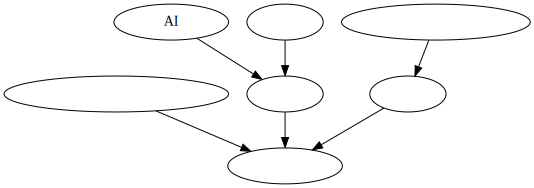

In [22]:
sent = text[33]

G = Digraph(format='svg')

# 節を作る
for i, chunk in enumerate(sent):
    G.node(str(i), str(chunk))
    
# 枝を作る
for i, chunk in enumerate(sent):
    if chunk.dst != -1:
        G.edge(str(i), str(chunk.dst))
    
G

### 45. 動詞の格パターンの抽出

In [23]:
def get_first_verb(chunk):
    for morph in chunk:
        if morph.pos == '動詞':
            return morph.base

def get_last_case(chunk):
    for morph in chunk[::-1]:
        if morph.pos == '助詞':
            return morph.surface
        
def extract_case_patterns(sent):
    patterns = []
    for chunk in sent:
        if verb := get_first_verb(chunk): # チャンク最初の動詞
            srcs = [sent[src] for src in chunk.srcs]
            cases = [case for src in srcs if (case := get_last_case(src))] # 係り元のチャンクの最後の助詞
            if cases:
                patterns.append((verb, cases))
    return patterns

In [24]:
with open('result/case_pattern.txt', 'w') as f:
    for sent in text:
        patterns = extract_case_patterns(sent)
        for verb, cases in patterns:
            line = '{}\t{}'.format(verb, ' '.join(cases))
            print(line, file=f)

In [25]:
! cat result/case_pattern.txt | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

     51 する	を
     22 する	と
     17 する	が
     16 する	は を
     10 する	に
     10 する	て を
      9 よる	の
      8 する	は と
      7 行う	を
      7 する	は


In [26]:
! cat result/case_pattern.txt | grep 'する' | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

     51 する	を
     22 する	と
     17 する	が
     16 する	は を
     10 する	に
     10 する	て を
      8 する	は と
      7 する	は
      7 する	て
      6 する	は が


In [27]:
! cat result/case_pattern.txt | grep '見る' | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

      1 見る	を て から
      1 見る	は も
      1 見る	が


In [28]:
! cat result/case_pattern.txt | grep '与える' | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

      1 与える	は に を
      1 与える	が に
      1 与える	が


### 46. 動詞の格フレーム情報の抽出

In [29]:
def extract_args(srcs):
    cases = []
    args = []
    for src in srcs:
        if case := get_last_case(src): # 係り元のチャンクの最後の助詞
            cases.append(case)
            args.append(str(src))
    return cases, args

def extract_case_frames(sent):
    frames = []
    for chunk in sent:
        if verb := get_first_verb(chunk): # チャンク最初の動詞
            srcs = [sent[src] for src in chunk.srcs]
            cases, args = extract_args(srcs)
            if cases:
                frames.append((verb, cases, args))
    return frames

In [30]:
for sent in text[:10]:
    frames = extract_case_frames(sent)
    for verb, cases, args in frames:
        line = '{}\t{}\t{}'.format(verb, ' '.join(cases), ' '.join(args))
        print(line)

いう	は	AI〈エーアイ〉）とは
いう	と	「『計算（）』という概念と
用いる	を	『コンピュータ（）』という道具を
する	て を	用いて 『知能』を
指す	を	一分野」を
代わる	を に	知的行動を 人間に
行う	て に	代わって コンピューターに
関する	や	設計や
する	も	研究分野」とも
述べる	で は	解説で 佐藤理史は
する	を で	知的能力を コンピュータ上で
する	を	推論・判断を
する	を	画像データを
する	て を	解析して パターンを
する	たり	検出・抽出したり
ある	は が	応用例は 画像認識等が
する	に で に	1956年に ダートマス会議で ジョン・マッカーシーにより
用いる	を	記号処理を
する	を と	記述を 主体と
いう	の	研究での
使う	は も	現在では 意味あいでも
呼ぶ	も	思考ルーチンも
する	を	カウンセラーを
出す	が に	プログラム（人工無脳）が 引き合いに
する	に を	計算機に 役割を
呼ぶ	と	「エキスパートシステム」と
持つ	が に	人間が 暗黙に
なる	が と	記述が 問題と
する	が は	出されるが 実現は


### 47. 機能動詞構文のマイニング

In [31]:
def is_sahen(chunk):
    return len(chunk) == 2 and chunk[0].pos2 == 'サ変可能' and chunk[1].surface == 'を'

def split_sahen(srcs):
    for i in range(len(srcs)):
        if is_sahen(srcs[i]):
            return str(srcs[i]), srcs[:i] + srcs[i+1:]
    return None, srcs

def extract_sahen_frames(sent):
    frames = []
    for chunk in sent:
        if verb := get_first_verb(chunk):
            srcs = [sent[src] for src in chunk.srcs]
            sahen, rest = split_sahen(srcs)
            cases, args = extract_args(srcs)
            if sahen and cases:
                frames.append((sahen + verb, cases, args))
    return frames

In [32]:
with open('result/sahen_frames.txt', 'w') as f:
    for sent in text:
        frames = extract_sahen_frames(sent)
        for sahen_verb, cases, args in frames:
            line = '{}\t{}\t{}'.format(sahen_verb, ' '.join(cases), ' '.join(args))
            print(line, file=f)

In [33]:
! cat result/sahen_frames.txt | cut -f 1 | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

      3 注目を集める
      2 研究をする
      2 運転をする
      1 話をする
      1 流行を超える
      1 命令をする
      1 普及を受ける
      1 反乱を起こす
      1 判断を介す
      1 投資を行う


In [34]:
! cat result/sahen_frames.txt | cut -f 1,2 | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

      1 話をする	ば は を
      1 流行を超える	を
      1 命令をする	を で
      1 普及を受ける	を
      1 反乱を起こす	て て を
      1 判断を介す	を
      1 投資を行う	で を
      1 投資をする	は を に を
      1 展開を変える	を
      1 追及を受ける	て は に で を


### 48. 名詞から根へのパスの抽出 

In [35]:
def trace(n, sent):
    path = []
    while n != -1:
        path.append(n)
        n = sent[n].dst
    return path

In [36]:
sent = text[33]
heads = [n for n in range(len(sent)) if has_noun(sent[n])]
for head in heads:
    path = trace(head, sent)
    path = ' -> '.join([str(sent[n]) for n in path])
    print(path)

ジョン・マッカーシーは -> 作り出した
AIに関する -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
「人工知能」という -> 用語を -> 作り出した
用語を -> 作り出した


### 49. 名詞間の係り受けパスの抽出

In [37]:
def extract_path(x, y, sent):
    xs = []
    ys = []
    while x != y:
        if x < y:
            xs.append(x)
            x = sent[x].dst
        else:
            ys.append(y)
            y = sent[y].dst
    return xs, ys, x

def remove_initial_nouns(chunk):
    for i, morph in enumerate(chunk):
        if morph.pos != '名詞' and morph.pos != '補助記号':
            break
    return ''.join([str(morph) for morph in chunk[i:]]).strip()

def path_to_str(xs, ys, last, sent):
    xs = [sent[x] for x in xs]
    ys = [sent[y] for y in ys]
    last = sent[last]
    if xs and ys:
        xs = ['X' + remove_initial_nouns(xs[0])] + [str(x) for x in xs[1:]]
        ys = ['Y' + remove_initial_nouns(ys[0])] + [str(y) for y in ys[1:]]
        last = str(last)
        return ' -> '.join(xs) + ' | ' + ' -> '.join(ys) + ' | ' + last
    else:
        xs = xs + ys
        xs = ['X' + remove_initial_nouns(xs[0])] + [str(x) for x in xs[1:]]
        last = 'Y' + remove_initial_nouns(last)
        return ' -> '.join(xs + [last])

In [38]:
sent = text[33]

heads = [n for n in range(len(sent)) if has_noun(sent[n])]
print('パスの先頭:', heads)

pairs = [
    (heads[n], second)
    for n in range(len(heads))
    for second in heads[n + 1:]]
print('パスの先頭のペア: ', pairs)

print('係り受けのパス:')
for x, y in pairs:
    x_path, y_path, last = extract_path(x, y, sent)
    path = path_to_str(x_path, y_path, last, sent)
    print(path)

パスの先頭: [0, 1, 2, 3, 4, 5]
パスの先頭のペア:  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
係り受けのパス:
Xは | Yに関する -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する | Yの | 会議で
Xに関する -> Yで
Xに関する -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
